In [33]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = len(tokenizer)
vocab_size

30522

# Deprecated

In [4]:
'''

import os

song_dir = 'Songs'

songs_data = []

for filename in os.listdir(song_dir):
    if filename.endswith(".txt"):

        with open(os.path.join(song_dir, filename), 'r', encoding='utf-8') as file:
            lyrics = file.read()

        genre = filename.split('_')[0]  # Example: assuming filenames like 'Rock_song1.txt'
        songs_data.append({"lyrics": lyrics, "genre": genre})

unique_genres = set(song["genre"] for song in songs_data)
genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}
print(unique_genres)
labeled_songs = [(song["lyrics"], genre_to_id[song["genre"]]) for song in songs_data]

labeled_songs

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
'''

'\n\nimport os\n\nsong_dir = \'Songs\'\n\nsongs_data = []\n\nfor filename in os.listdir(song_dir):\n    if filename.endswith(".txt"):\n\n        with open(os.path.join(song_dir, filename), \'r\', encoding=\'utf-8\') as file:\n            lyrics = file.read()\n\n        genre = filename.split(\'_\')[0]  # Example: assuming filenames like \'Rock_song1.txt\'\n        songs_data.append({"lyrics": lyrics, "genre": genre})\n\nunique_genres = set(song["genre"] for song in songs_data)\ngenre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}\nprint(unique_genres)\nlabeled_songs = [(song["lyrics"], genre_to_id[song["genre"]]) for song in songs_data]\n\nlabeled_songs\n\ninput_ids = torch.cat(input_ids, dim=0)\nattention_masks = torch.cat(attention_masks, dim=0)\nlabels = torch.tensor(labels)\n'

In [34]:
import pandas as pd

file_path = 'sampled_songs.csv'
df = pd.read_csv(file_path)

# bert's not as good with other languages
df = df[df['language'] == 'en']

genres = df['tag'].tolist()
lyrics = df['lyrics'].tolist()

unique_genres = set(genres)
genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}


In [51]:
tokenized_data = [tokenizer.encode_plus(
    lyric,
    add_special_tokens=True,
    max_length=300,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
) for lyric in lyrics]

In [52]:
import torch

input_ids = torch.cat([item['input_ids'] for item in tokenized_data], dim=0)
attention_masks = torch.cat([item['attention_mask'] for item in tokenized_data], dim=0)
labels = torch.tensor([genre_to_id[genre] for genre in genres])

# print("Lyrics:", labeled_songs[0][0])
print("Token IDs:", input_ids[0])
print("Attention Mask:", attention_masks[0])
print("Label:", labels[0])

Token IDs: tensor([  101,  1031,  7893,  1015,  1033,  2017,  8966,  2115,  4253,  1998,
         2035,  2115,  4933,  1005, 18681,  2045,  2001,  2498,  2187,  1997,
         2149,  3984,  2054,  2057,  2018,  7110,  1005,  1056,  2438,  2008,
         4949,  3875,  2017,  2006,  1996,  2835,  2003,  5559,  2157,  2073,
         1045, 10587,  2022,  4299,  1045,  2071,  2644,  2115,  2975,  2033,
         1031,  7165,  1033,  2021,  2053,  3043,  2129,  2521,  2017,  2175,
         2026,  2293,  2003,  2844,  1010,  2180,  1005,  1056,  4558,  1037,
         2907,  2074,  3426,  2017,  1005,  2128,  2908,  2180,  1005,  1056,
         2812,  2057,  1005,  2310,  5419,  1045,  2064,  2145,  2293,  2017,
         2013,  2182,  1031,  7893,  1016,  1033,  2009,  1005,  1055,  2115,
         3247,  1010,  2009,  1005,  1055,  2025,  3067,  2017,  1005,  2128,
         1996,  2028,  2040,  3881,  2023,  2240,  1045,  2113,  1045,  2064,
         1005,  1056,  2689,  2115,  2568,  2017,  24

In [65]:
print(len(labels))

6527


In [53]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        encoding = self.encoding.to(x.device)
        return x + encoding[:, :x.size(1)].detach()

def scaled_dot_product_attention(query, key, value, mask=None):
    matmul_qk = torch.matmul(query, key.transpose(-2, -1))
    d_k = query.size(-1)
    scaled_attention_logits = matmul_qk / math.sqrt(d_k)

    # print("Shape of query: ", query.shape)
    # print("Shape of key: ", key.shape)
    # print("Shape of value: ", value.shape)
    # print("Shape of matmul_qk (attention logits): ", matmul_qk.shape)

    # matmul_qk is shaped [6, 8, 512, 512], where the 8 is the 8 attention heads

    # mask is shaped [6, 512] from preprocessing

    # need to add two filler dimensions 
    mask = mask.unsqueeze(1).unsqueeze(1)

    # if mask is not None:
    #     print("Shape of mask: ", mask.shape)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = nn.Softmax(dim=-1)(scaled_attention_logits)
    output = torch.matmul(attention_weights, value)
    return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

    def split_into_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, v, k, q, mask):
        batch_size = q.size(0)
        q = self.split_into_heads(self.wq(q), batch_size)
        k = self.split_into_heads(self.wk(k), batch_size)
        v = self.split_into_heads(self.wv(v), batch_size)
        attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        attention = attention.permute(0, 2, 1, 3).contiguous()
        concat_attention = attention.view(batch_size, -1, self.d_model)
        output = self.dense(concat_attention)
        return output, attention_weights

class PointwiseFeedforwardNetwork(nn.Module):
    def __init__(self, d_model, d_fforward):
        super(PointwiseFeedforwardNetwork, self).__init__()
        self.linear1 = nn.Linear(d_model, d_fforward)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_fforward, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_fforward, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = PointwiseFeedforwardNetwork(d_model, d_fforward)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output, _ = self.attention(x, x, x, mask)
        x = self.norm1(x + attn_output)
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_fforward, num_classes, max_len=512):
        super(TransformerModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.transformer_block = TransformerBlock(d_model, num_heads, d_fforward)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        embeddings = self.embeddings(input_ids)
        embeddings = self.pos_encoder(embeddings)
        transformer_output = self.transformer_block(embeddings, attention_mask)
        output = self.classifier(transformer_output[:, 0])
        return nn.functional.softmax(output, dim=1)

In [54]:
# # Make sure the model is in evaluation mode
# model.eval()

# with torch.no_grad():  # Turn off gradients for prediction
#     # Forward pass, get logit predictions
#     output = model(input_ids[0], attention_masks[0])

# # The output is the softmax output giving probabilities for each genre
# print(output)

# Model Testing

In [66]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)


In [67]:
d_model = 512
num_heads = 8
d_fforward = 1024
num_classes = len(unique_genres)  # [Pop, Rock, Rap, Country, R&B]
model = TransformerModel(vocab_size, d_model, num_heads, d_fforward, num_classes)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Move your model to the device
model.to(device)

# When processing data, you also need to move your tensors to the MPS device
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

Using device: mps


In [68]:
from tqdm import tqdm
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion.to(device)

def calculate_accuracy(predictions, labels):
    preds = torch.argmax(predictions, dim=1).flatten()
    correct_preds = (preds == labels).cpu().sum().item()
    total_preds = labels.size(0)
    accuracy = correct_preds / total_preds
    return accuracy

num_epochs = 18
train_loss_history = []
train_accuracy_history = []

model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_dataloader, leave=True, total=len(train_dataloader))

    total_loss = 0
    total_accuracy = 0

    for batch in loop:

        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()

        outputs = model(b_input_ids, b_input_mask)

        loss = criterion(outputs, b_labels)
        accuracy = calculate_accuracy(outputs, b_labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy

        loop.set_description(f'Epoch {epoch + 1}/{num_epochs}')
        loop.set_postfix(loss=loss.item(), accuracy=accuracy)

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)
    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(avg_train_accuracy)
    print(f'Epoch {epoch + 1} finished - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}')

Epoch 1/18: 100%|██████████| 204/204 [00:11<00:00, 17.06it/s, accuracy=0.452, loss=1.59]


Epoch 1 finished - Loss: 1.5549, Accuracy: 0.4878


Epoch 2/18: 100%|██████████| 204/204 [00:11<00:00, 17.47it/s, accuracy=0.419, loss=1.62]


Epoch 2 finished - Loss: 1.5495, Accuracy: 0.4923


Epoch 3/18: 100%|██████████| 204/204 [00:11<00:00, 17.51it/s, accuracy=0.581, loss=1.46]


Epoch 3 finished - Loss: 1.5174, Accuracy: 0.5218


Epoch 4/18: 100%|██████████| 204/204 [00:11<00:00, 17.53it/s, accuracy=0.484, loss=1.57]


Epoch 4 finished - Loss: 1.4869, Accuracy: 0.5554


Epoch 5/18: 100%|██████████| 204/204 [00:11<00:00, 17.53it/s, accuracy=0.645, loss=1.4] 


Epoch 5 finished - Loss: 1.4802, Accuracy: 0.5628


Epoch 6/18: 100%|██████████| 204/204 [00:11<00:00, 17.53it/s, accuracy=0.548, loss=1.5] 


Epoch 6 finished - Loss: 1.4787, Accuracy: 0.5638


Epoch 7/18: 100%|██████████| 204/204 [00:11<00:00, 17.53it/s, accuracy=0.419, loss=1.62]


Epoch 7 finished - Loss: 1.4793, Accuracy: 0.5632


Epoch 8/18: 100%|██████████| 204/204 [00:11<00:00, 17.54it/s, accuracy=0.645, loss=1.39]


Epoch 8 finished - Loss: 1.4773, Accuracy: 0.5655


Epoch 9/18: 100%|██████████| 204/204 [00:11<00:00, 17.48it/s, accuracy=0.548, loss=1.5] 


Epoch 9 finished - Loss: 1.4735, Accuracy: 0.5683


Epoch 10/18: 100%|██████████| 204/204 [00:11<00:00, 17.64it/s, accuracy=0.677, loss=1.37]


Epoch 10 finished - Loss: 1.4627, Accuracy: 0.5802


Epoch 11/18: 100%|██████████| 204/204 [00:11<00:00, 17.49it/s, accuracy=0.581, loss=1.46]


Epoch 11 finished - Loss: 1.4590, Accuracy: 0.5836


Epoch 12/18: 100%|██████████| 204/204 [00:11<00:00, 17.77it/s, accuracy=0.548, loss=1.48]


Epoch 12 finished - Loss: 1.4540, Accuracy: 0.5877


Epoch 13/18: 100%|██████████| 204/204 [00:11<00:00, 17.60it/s, accuracy=0.71, loss=1.33] 


Epoch 13 finished - Loss: 1.4468, Accuracy: 0.5963


Epoch 14/18: 100%|██████████| 204/204 [00:11<00:00, 17.51it/s, accuracy=0.71, loss=1.34] 


Epoch 14 finished - Loss: 1.4484, Accuracy: 0.5945


Epoch 15/18: 100%|██████████| 204/204 [00:11<00:00, 17.79it/s, accuracy=0.645, loss=1.4] 


Epoch 15 finished - Loss: 1.4428, Accuracy: 0.5997


Epoch 16/18: 100%|██████████| 204/204 [00:11<00:00, 17.93it/s, accuracy=0.677, loss=1.37]


Epoch 16 finished - Loss: 1.4420, Accuracy: 0.6007


Epoch 17/18: 100%|██████████| 204/204 [00:11<00:00, 18.05it/s, accuracy=0.516, loss=1.53]


Epoch 17 finished - Loss: 1.4419, Accuracy: 0.6001


Epoch 18/18: 100%|██████████| 204/204 [00:11<00:00, 18.12it/s, accuracy=0.548, loss=1.51]

Epoch 18 finished - Loss: 1.4424, Accuracy: 0.6007


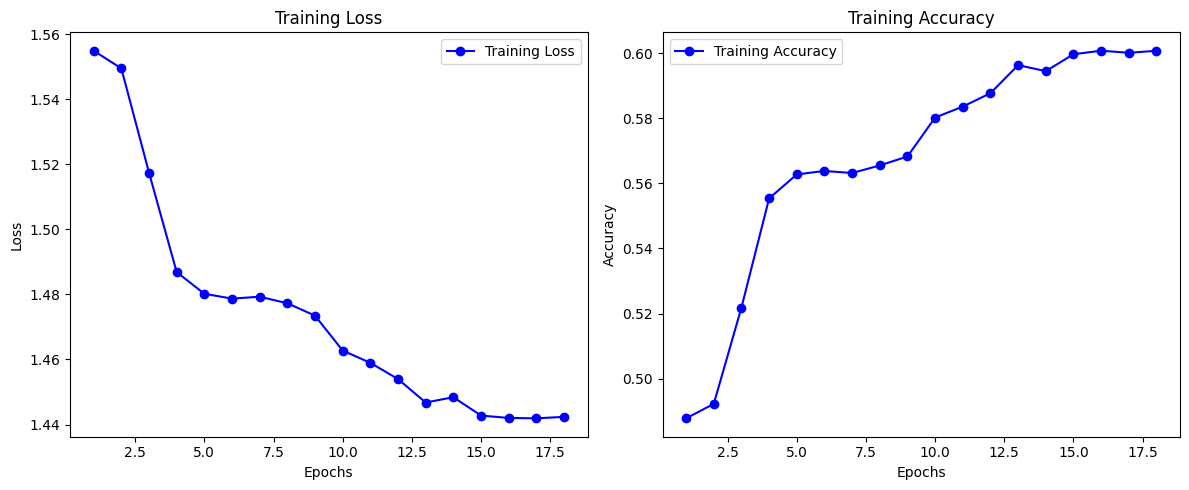

In [71]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_history, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [70]:
# Make sure the model is in evaluation mode
model.eval()

with torch.no_grad():  # Turn off gradients for prediction
    # Forward pass, get logit predictions
    # Add a batch dimension using unsqueeze(0)
    output = model(input_ids[1].unsqueeze(0), attention_masks[1].unsqueeze(0))

# The output is the softmax output giving probabilities for each genre
print("Lyrics:", labeled_songs[1][0])
print(output)
print(unique_genres)
print(labels[1])

NameError: name 'labeled_songs' is not defined